In [24]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut

from sampler import sample_from_logreg

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
#X, y = load_breast_cancer(return_X_y=True)
#X, y = make_classification(n_samples=250, n_features=50)
X, _, y = sample_from_logreg(n=250, p=20)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X_scaled = StandardScaler().fit_transform(X)
#X_scaled = X
print(X_scaled.shape)

(250, 20)


In [4]:
clf = SVC(kernel='linear')
clf.fit(X_scaled, y)
sk_coef_og = clf.coef_.flatten()
sk_coef = clf.coef_/np.linalg.norm(clf.coef_)
print(clf.coef_)
print(clf.intercept_)

[[ 0.27195417 -0.15970433  0.06787314 -0.14178334  0.20751936 -0.46086391
  -0.04684095  0.30977799 -0.03479087 -0.11736148 -0.2070929  -0.07651014
   0.12510314 -0.1849915   0.13385014 -0.18668356 -0.00919532  0.07954967
   0.14239288 -0.39788942]]
[-0.49164275]


In [5]:
y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

0.656

In [6]:
clf = SVM_smooth(sigma=2e-1, lbd=1)
clf.fit(X_scaled, y, thresh=0, n_iter=7000, eta=0.5/n,
        approx_cv=True, cv=True, log_iter=True, log_iacv=True,
        save_cond_nums=True, save_err_approx=True, save_err_cv=True, warm_start=0, normalise=False, include_lambda_grad=False)
print(f"grad {np.linalg.norm(clf.nabla_fgd_(clf.weights_, X_scaled, y, clf.sigma_, clf.lbd_))}")
coef = clf.weights_/np.linalg.norm(clf.weights_)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

y_pred = clf.predict(X_scaled)
accuracy_score(y, y_pred)

2024-01-24 23:51:37.437973: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


iter 0 | grad 0.31201 | objective 1.00990 | IACV: 0.00000000 | baseline: 0.00062248
iter 1 | grad 0.31137 | objective 1.01002 | IACV: 0.00000000 | baseline: 0.00062159
iter 2 | grad 0.31074 | objective 1.01014 | IACV: 0.00000000 | baseline: 0.00062262
iter 3 | grad 0.31010 | objective 1.01025 | IACV: 0.00000000 | baseline: 0.00062555
iter 4 | grad 0.30947 | objective 1.01037 | IACV: 0.00000000 | baseline: 0.00063036
iter 5 | grad 0.30884 | objective 1.01049 | IACV: 0.00000001 | baseline: 0.00063699
iter 6 | grad 0.30821 | objective 1.01060 | IACV: 0.00000001 | baseline: 0.00064537
iter 7 | grad 0.30758 | objective 1.01072 | IACV: 0.00000001 | baseline: 0.00065545
iter 8 | grad 0.30695 | objective 1.01083 | IACV: 0.00000001 | baseline: 0.00066713
iter 9 | grad 0.30633 | objective 1.01095 | IACV: 0.00000002 | baseline: 0.00068032
iter 10 | grad 0.30570 | objective 1.01106 | IACV: 0.00000002 | baseline: 0.00069495
iter 11 | grad 0.30508 | objective 1.01118 | IACV: 0.00000002 | baseline: 0

iter 103 | grad 0.25271 | objective 1.02084 | IACV: 0.00000164 | baseline: 0.00328161
iter 104 | grad 0.25220 | objective 1.02094 | IACV: 0.00000167 | baseline: 0.00330947
iter 105 | grad 0.25168 | objective 1.02104 | IACV: 0.00000170 | baseline: 0.00333728
iter 106 | grad 0.25116 | objective 1.02113 | IACV: 0.00000173 | baseline: 0.00336504
iter 107 | grad 0.25065 | objective 1.02123 | IACV: 0.00000176 | baseline: 0.00339275
iter 108 | grad 0.25013 | objective 1.02132 | IACV: 0.00000179 | baseline: 0.00342041
iter 109 | grad 0.24962 | objective 1.02142 | IACV: 0.00000182 | baseline: 0.00344802
iter 110 | grad 0.24911 | objective 1.02151 | IACV: 0.00000185 | baseline: 0.00347558
iter 111 | grad 0.24860 | objective 1.02160 | IACV: 0.00000189 | baseline: 0.00350309
iter 112 | grad 0.24809 | objective 1.02170 | IACV: 0.00000192 | baseline: 0.00353056
iter 113 | grad 0.24758 | objective 1.02179 | IACV: 0.00000195 | baseline: 0.00355797
iter 114 | grad 0.24707 | objective 1.02189 | IACV: 0.

iter 207 | grad 0.20403 | objective 1.02984 | IACV: 0.00000590 | baseline: 0.00591308
iter 208 | grad 0.20361 | objective 1.02992 | IACV: 0.00000595 | baseline: 0.00593585
iter 209 | grad 0.20319 | objective 1.03000 | IACV: 0.00000600 | baseline: 0.00595856
iter 210 | grad 0.20277 | objective 1.03007 | IACV: 0.00000605 | baseline: 0.00598124
iter 211 | grad 0.20235 | objective 1.03015 | IACV: 0.00000610 | baseline: 0.00600386
iter 212 | grad 0.20194 | objective 1.03023 | IACV: 0.00000615 | baseline: 0.00602644
iter 213 | grad 0.20152 | objective 1.03031 | IACV: 0.00000621 | baseline: 0.00604898
iter 214 | grad 0.20110 | objective 1.03038 | IACV: 0.00000626 | baseline: 0.00607147
iter 215 | grad 0.20069 | objective 1.03046 | IACV: 0.00000631 | baseline: 0.00609391
iter 216 | grad 0.20027 | objective 1.03054 | IACV: 0.00000636 | baseline: 0.00611631
iter 217 | grad 0.19986 | objective 1.03061 | IACV: 0.00000641 | baseline: 0.00613866
iter 218 | grad 0.19945 | objective 1.03069 | IACV: 0.

iter 311 | grad 0.16446 | objective 1.03715 | IACV: 0.00001198 | baseline: 0.00804806
iter 312 | grad 0.16412 | objective 1.03721 | IACV: 0.00001205 | baseline: 0.00806645
iter 313 | grad 0.16378 | objective 1.03728 | IACV: 0.00001211 | baseline: 0.00808480
iter 314 | grad 0.16344 | objective 1.03734 | IACV: 0.00001218 | baseline: 0.00810312
iter 315 | grad 0.16310 | objective 1.03740 | IACV: 0.00001224 | baseline: 0.00812139
iter 316 | grad 0.16276 | objective 1.03746 | IACV: 0.00001231 | baseline: 0.00813963
iter 317 | grad 0.16242 | objective 1.03753 | IACV: 0.00001237 | baseline: 0.00815783
iter 318 | grad 0.16208 | objective 1.03759 | IACV: 0.00001244 | baseline: 0.00817599
iter 319 | grad 0.16174 | objective 1.03765 | IACV: 0.00001251 | baseline: 0.00819412
iter 320 | grad 0.16140 | objective 1.03771 | IACV: 0.00001257 | baseline: 0.00821220
iter 321 | grad 0.16107 | objective 1.03778 | IACV: 0.00001264 | baseline: 0.00823025
iter 322 | grad 0.16073 | objective 1.03784 | IACV: 0.

iter 414 | grad 0.13256 | objective 1.04303 | IACV: 0.00001924 | baseline: 0.00975448
iter 415 | grad 0.13228 | objective 1.04308 | IACV: 0.00001931 | baseline: 0.00976931
iter 416 | grad 0.13200 | objective 1.04313 | IACV: 0.00001939 | baseline: 0.00978411
iter 417 | grad 0.13173 | objective 1.04318 | IACV: 0.00001946 | baseline: 0.00979888
iter 418 | grad 0.13145 | objective 1.04323 | IACV: 0.00001954 | baseline: 0.00981361
iter 419 | grad 0.13117 | objective 1.04328 | IACV: 0.00001961 | baseline: 0.00982832
iter 420 | grad 0.13090 | objective 1.04333 | IACV: 0.00001969 | baseline: 0.00984299
iter 421 | grad 0.13062 | objective 1.04338 | IACV: 0.00001976 | baseline: 0.00985763
iter 422 | grad 0.13035 | objective 1.04343 | IACV: 0.00001984 | baseline: 0.00987224
iter 423 | grad 0.13007 | objective 1.04348 | IACV: 0.00001992 | baseline: 0.00988682
iter 424 | grad 0.12980 | objective 1.04353 | IACV: 0.00001999 | baseline: 0.00990137
iter 425 | grad 0.12952 | objective 1.04358 | IACV: 0.

iter 517 | grad 0.10657 | objective 1.04779 | IACV: 0.00002731 | baseline: 0.01112822
iter 518 | grad 0.10635 | objective 1.04783 | IACV: 0.00002739 | baseline: 0.01114014
iter 519 | grad 0.10612 | objective 1.04787 | IACV: 0.00002747 | baseline: 0.01115203
iter 520 | grad 0.10589 | objective 1.04792 | IACV: 0.00002755 | baseline: 0.01116389
iter 521 | grad 0.10567 | objective 1.04796 | IACV: 0.00002763 | baseline: 0.01117573
iter 522 | grad 0.10544 | objective 1.04800 | IACV: 0.00002772 | baseline: 0.01118755
iter 523 | grad 0.10522 | objective 1.04804 | IACV: 0.00002780 | baseline: 0.01119934
iter 524 | grad 0.10499 | objective 1.04808 | IACV: 0.00002788 | baseline: 0.01121110
iter 525 | grad 0.10477 | objective 1.04812 | IACV: 0.00002796 | baseline: 0.01122284
iter 526 | grad 0.10455 | objective 1.04816 | IACV: 0.00002804 | baseline: 0.01123455
iter 527 | grad 0.10432 | objective 1.04820 | IACV: 0.00002812 | baseline: 0.01124624
iter 528 | grad 0.10410 | objective 1.04824 | IACV: 0.

iter 621 | grad 0.08523 | objective 1.05168 | IACV: 0.00003598 | baseline: 0.01223968
iter 622 | grad 0.08505 | objective 1.05171 | IACV: 0.00003607 | baseline: 0.01224920
iter 623 | grad 0.08487 | objective 1.05175 | IACV: 0.00003615 | baseline: 0.01225869
iter 624 | grad 0.08468 | objective 1.05178 | IACV: 0.00003624 | baseline: 0.01226817
iter 625 | grad 0.08450 | objective 1.05181 | IACV: 0.00003633 | baseline: 0.01227763
iter 626 | grad 0.08432 | objective 1.05185 | IACV: 0.00003641 | baseline: 0.01228706
iter 627 | grad 0.08413 | objective 1.05188 | IACV: 0.00003650 | baseline: 0.01229647
iter 628 | grad 0.08395 | objective 1.05191 | IACV: 0.00003658 | baseline: 0.01230587
iter 629 | grad 0.08377 | objective 1.05194 | IACV: 0.00003667 | baseline: 0.01231524
iter 630 | grad 0.08359 | objective 1.05198 | IACV: 0.00003675 | baseline: 0.01232459
iter 631 | grad 0.08341 | objective 1.05201 | IACV: 0.00003684 | baseline: 0.01233393
iter 632 | grad 0.08323 | objective 1.05204 | IACV: 0.

iter 725 | grad 0.06793 | objective 1.05481 | IACV: 0.00004498 | baseline: 0.01312561
iter 726 | grad 0.06778 | objective 1.05483 | IACV: 0.00004507 | baseline: 0.01313318
iter 727 | grad 0.06763 | objective 1.05486 | IACV: 0.00004516 | baseline: 0.01314073
iter 728 | grad 0.06748 | objective 1.05489 | IACV: 0.00004525 | baseline: 0.01314827
iter 729 | grad 0.06734 | objective 1.05491 | IACV: 0.00004534 | baseline: 0.01315578
iter 730 | grad 0.06719 | objective 1.05494 | IACV: 0.00004542 | baseline: 0.01316329
iter 731 | grad 0.06704 | objective 1.05497 | IACV: 0.00004551 | baseline: 0.01317077
iter 732 | grad 0.06689 | objective 1.05499 | IACV: 0.00004560 | baseline: 0.01317824
iter 733 | grad 0.06675 | objective 1.05502 | IACV: 0.00004569 | baseline: 0.01318569
iter 734 | grad 0.06660 | objective 1.05505 | IACV: 0.00004577 | baseline: 0.01319312
iter 735 | grad 0.06645 | objective 1.05507 | IACV: 0.00004586 | baseline: 0.01320054
iter 736 | grad 0.06631 | objective 1.05510 | IACV: 0.

iter 829 | grad 0.05394 | objective 1.05731 | IACV: 0.00005421 | baseline: 0.01382856
iter 830 | grad 0.05382 | objective 1.05733 | IACV: 0.00005429 | baseline: 0.01383455
iter 831 | grad 0.05370 | objective 1.05735 | IACV: 0.00005438 | baseline: 0.01384052
iter 832 | grad 0.05358 | objective 1.05737 | IACV: 0.00005447 | baseline: 0.01384649
iter 833 | grad 0.05346 | objective 1.05740 | IACV: 0.00005456 | baseline: 0.01385244
iter 834 | grad 0.05334 | objective 1.05742 | IACV: 0.00005465 | baseline: 0.01385837
iter 835 | grad 0.05322 | objective 1.05744 | IACV: 0.00005474 | baseline: 0.01386430
iter 836 | grad 0.05310 | objective 1.05746 | IACV: 0.00005483 | baseline: 0.01387021
iter 837 | grad 0.05298 | objective 1.05748 | IACV: 0.00005492 | baseline: 0.01387610
iter 838 | grad 0.05286 | objective 1.05750 | IACV: 0.00005501 | baseline: 0.01388198
iter 839 | grad 0.05275 | objective 1.05752 | IACV: 0.00005510 | baseline: 0.01388785
iter 840 | grad 0.05263 | objective 1.05754 | IACV: 0.

iter 933 | grad 0.04267 | objective 1.05931 | IACV: 0.00006358 | baseline: 0.01438368
iter 934 | grad 0.04258 | objective 1.05933 | IACV: 0.00006367 | baseline: 0.01438840
iter 935 | grad 0.04248 | objective 1.05934 | IACV: 0.00006376 | baseline: 0.01439311
iter 936 | grad 0.04238 | objective 1.05936 | IACV: 0.00006385 | baseline: 0.01439781
iter 937 | grad 0.04229 | objective 1.05938 | IACV: 0.00006394 | baseline: 0.01440249
iter 938 | grad 0.04219 | objective 1.05939 | IACV: 0.00006403 | baseline: 0.01440717
iter 939 | grad 0.04210 | objective 1.05941 | IACV: 0.00006412 | baseline: 0.01441183
iter 940 | grad 0.04200 | objective 1.05943 | IACV: 0.00006421 | baseline: 0.01441649
iter 941 | grad 0.04190 | objective 1.05944 | IACV: 0.00006430 | baseline: 0.01442113
iter 942 | grad 0.04181 | objective 1.05946 | IACV: 0.00006439 | baseline: 0.01442576
iter 943 | grad 0.04171 | objective 1.05948 | IACV: 0.00006448 | baseline: 0.01443038
iter 944 | grad 0.04162 | objective 1.05949 | IACV: 0.

iter 1034 | grad 0.03388 | objective 1.06086 | IACV: 0.00007274 | baseline: 0.01480892
iter 1035 | grad 0.03380 | objective 1.06087 | IACV: 0.00007283 | baseline: 0.01481265
iter 1036 | grad 0.03372 | objective 1.06088 | IACV: 0.00007292 | baseline: 0.01481637
iter 1037 | grad 0.03364 | objective 1.06090 | IACV: 0.00007301 | baseline: 0.01482008
iter 1038 | grad 0.03357 | objective 1.06091 | IACV: 0.00007310 | baseline: 0.01482378
iter 1039 | grad 0.03349 | objective 1.06092 | IACV: 0.00007319 | baseline: 0.01482747
iter 1040 | grad 0.03341 | objective 1.06094 | IACV: 0.00007328 | baseline: 0.01483115
iter 1041 | grad 0.03333 | objective 1.06095 | IACV: 0.00007337 | baseline: 0.01483483
iter 1042 | grad 0.03326 | objective 1.06096 | IACV: 0.00007346 | baseline: 0.01483850
iter 1043 | grad 0.03318 | objective 1.06098 | IACV: 0.00007355 | baseline: 0.01484215
iter 1044 | grad 0.03310 | objective 1.06099 | IACV: 0.00007364 | baseline: 0.01484580
iter 1045 | grad 0.03303 | objective 1.0610

iter 1139 | grad 0.02657 | objective 1.06213 | IACV: 0.00008218 | baseline: 0.01515593
iter 1140 | grad 0.02650 | objective 1.06214 | IACV: 0.00008226 | baseline: 0.01515884
iter 1141 | grad 0.02644 | objective 1.06215 | IACV: 0.00008235 | baseline: 0.01516174
iter 1142 | grad 0.02638 | objective 1.06216 | IACV: 0.00008244 | baseline: 0.01516463
iter 1143 | grad 0.02632 | objective 1.06217 | IACV: 0.00008253 | baseline: 0.01516752
iter 1144 | grad 0.02626 | objective 1.06218 | IACV: 0.00008262 | baseline: 0.01517039
iter 1145 | grad 0.02620 | objective 1.06219 | IACV: 0.00008271 | baseline: 0.01517327
iter 1146 | grad 0.02614 | objective 1.06220 | IACV: 0.00008280 | baseline: 0.01517613
iter 1147 | grad 0.02608 | objective 1.06222 | IACV: 0.00008289 | baseline: 0.01517899
iter 1148 | grad 0.02602 | objective 1.06223 | IACV: 0.00008297 | baseline: 0.01518184
iter 1149 | grad 0.02595 | objective 1.06224 | IACV: 0.00008306 | baseline: 0.01518468
iter 1150 | grad 0.02589 | objective 1.0622

iter 1243 | grad 0.02083 | objective 1.06312 | IACV: 0.00009125 | baseline: 0.01542380
iter 1244 | grad 0.02078 | objective 1.06313 | IACV: 0.00009133 | baseline: 0.01542606
iter 1245 | grad 0.02073 | objective 1.06314 | IACV: 0.00009142 | baseline: 0.01542832
iter 1246 | grad 0.02068 | objective 1.06315 | IACV: 0.00009150 | baseline: 0.01543057
iter 1247 | grad 0.02063 | objective 1.06316 | IACV: 0.00009159 | baseline: 0.01543282
iter 1248 | grad 0.02059 | objective 1.06317 | IACV: 0.00009167 | baseline: 0.01543506
iter 1249 | grad 0.02054 | objective 1.06317 | IACV: 0.00009176 | baseline: 0.01543730
iter 1250 | grad 0.02049 | objective 1.06318 | IACV: 0.00009184 | baseline: 0.01543953
iter 1251 | grad 0.02044 | objective 1.06319 | IACV: 0.00009193 | baseline: 0.01544176
iter 1252 | grad 0.02039 | objective 1.06320 | IACV: 0.00009201 | baseline: 0.01544398
iter 1253 | grad 0.02035 | objective 1.06321 | IACV: 0.00009210 | baseline: 0.01544620
iter 1254 | grad 0.02030 | objective 1.0632

iter 1346 | grad 0.01634 | objective 1.06390 | IACV: 0.00009977 | baseline: 0.01563049
iter 1347 | grad 0.01630 | objective 1.06390 | IACV: 0.00009985 | baseline: 0.01563226
iter 1348 | grad 0.01626 | objective 1.06391 | IACV: 0.00009993 | baseline: 0.01563402
iter 1349 | grad 0.01622 | objective 1.06392 | IACV: 0.00010001 | baseline: 0.01563577
iter 1350 | grad 0.01618 | objective 1.06392 | IACV: 0.00010009 | baseline: 0.01563752
iter 1351 | grad 0.01615 | objective 1.06393 | IACV: 0.00010017 | baseline: 0.01563927
iter 1352 | grad 0.01611 | objective 1.06394 | IACV: 0.00010025 | baseline: 0.01564101
iter 1353 | grad 0.01607 | objective 1.06394 | IACV: 0.00010033 | baseline: 0.01564275
iter 1354 | grad 0.01603 | objective 1.06395 | IACV: 0.00010041 | baseline: 0.01564449
iter 1355 | grad 0.01599 | objective 1.06396 | IACV: 0.00010049 | baseline: 0.01564622
iter 1356 | grad 0.01596 | objective 1.06396 | IACV: 0.00010057 | baseline: 0.01564794
iter 1357 | grad 0.01592 | objective 1.0639

iter 1448 | grad 0.01283 | objective 1.06450 | IACV: 0.00010761 | baseline: 0.01579005
iter 1449 | grad 0.01280 | objective 1.06451 | IACV: 0.00010768 | baseline: 0.01579142
iter 1450 | grad 0.01277 | objective 1.06451 | IACV: 0.00010776 | baseline: 0.01579280
iter 1451 | grad 0.01274 | objective 1.06452 | IACV: 0.00010783 | baseline: 0.01579417
iter 1452 | grad 0.01271 | objective 1.06452 | IACV: 0.00010790 | baseline: 0.01579553
iter 1453 | grad 0.01268 | objective 1.06453 | IACV: 0.00010798 | baseline: 0.01579690
iter 1454 | grad 0.01265 | objective 1.06453 | IACV: 0.00010805 | baseline: 0.01579825
iter 1455 | grad 0.01262 | objective 1.06454 | IACV: 0.00010812 | baseline: 0.01579961
iter 1456 | grad 0.01259 | objective 1.06454 | IACV: 0.00010820 | baseline: 0.01580096
iter 1457 | grad 0.01256 | objective 1.06455 | IACV: 0.00010827 | baseline: 0.01580231
iter 1458 | grad 0.01253 | objective 1.06455 | IACV: 0.00010834 | baseline: 0.01580366
iter 1459 | grad 0.01250 | objective 1.0645

iter 1552 | grad 0.01001 | objective 1.06498 | IACV: 0.00011488 | baseline: 0.01591657
iter 1553 | grad 0.00999 | objective 1.06499 | IACV: 0.00011495 | baseline: 0.01591763
iter 1554 | grad 0.00997 | objective 1.06499 | IACV: 0.00011501 | baseline: 0.01591870
iter 1555 | grad 0.00994 | objective 1.06499 | IACV: 0.00011508 | baseline: 0.01591976
iter 1556 | grad 0.00992 | objective 1.06500 | IACV: 0.00011514 | baseline: 0.01592082
iter 1557 | grad 0.00990 | objective 1.06500 | IACV: 0.00011521 | baseline: 0.01592187
iter 1558 | grad 0.00987 | objective 1.06501 | IACV: 0.00011528 | baseline: 0.01592293
iter 1559 | grad 0.00985 | objective 1.06501 | IACV: 0.00011534 | baseline: 0.01592398
iter 1560 | grad 0.00983 | objective 1.06501 | IACV: 0.00011541 | baseline: 0.01592503
iter 1561 | grad 0.00980 | objective 1.06502 | IACV: 0.00011547 | baseline: 0.01592607
iter 1562 | grad 0.00978 | objective 1.06502 | IACV: 0.00011554 | baseline: 0.01592712
iter 1563 | grad 0.00976 | objective 1.0650

iter 1655 | grad 0.00783 | objective 1.06535 | IACV: 0.00012132 | baseline: 0.01601380
iter 1656 | grad 0.00781 | objective 1.06536 | IACV: 0.00012138 | baseline: 0.01601463
iter 1657 | grad 0.00780 | objective 1.06536 | IACV: 0.00012143 | baseline: 0.01601546
iter 1658 | grad 0.00778 | objective 1.06536 | IACV: 0.00012149 | baseline: 0.01601628
iter 1659 | grad 0.00776 | objective 1.06537 | IACV: 0.00012155 | baseline: 0.01601710
iter 1660 | grad 0.00774 | objective 1.06537 | IACV: 0.00012161 | baseline: 0.01601792
iter 1661 | grad 0.00772 | objective 1.06537 | IACV: 0.00012167 | baseline: 0.01601874
iter 1662 | grad 0.00770 | objective 1.06538 | IACV: 0.00012173 | baseline: 0.01601956
iter 1663 | grad 0.00769 | objective 1.06538 | IACV: 0.00012179 | baseline: 0.01602037
iter 1664 | grad 0.00767 | objective 1.06538 | IACV: 0.00012184 | baseline: 0.01602119
iter 1665 | grad 0.00765 | objective 1.06539 | IACV: 0.00012190 | baseline: 0.01602200
iter 1666 | grad 0.00763 | objective 1.0653

iter 1756 | grad 0.00616 | objective 1.06564 | IACV: 0.00012689 | baseline: 0.01608803
iter 1757 | grad 0.00614 | objective 1.06564 | IACV: 0.00012694 | baseline: 0.01608868
iter 1758 | grad 0.00613 | objective 1.06565 | IACV: 0.00012699 | baseline: 0.01608932
iter 1759 | grad 0.00611 | objective 1.06565 | IACV: 0.00012704 | baseline: 0.01608997
iter 1760 | grad 0.00610 | objective 1.06565 | IACV: 0.00012710 | baseline: 0.01609061
iter 1761 | grad 0.00608 | objective 1.06565 | IACV: 0.00012715 | baseline: 0.01609125
iter 1762 | grad 0.00607 | objective 1.06566 | IACV: 0.00012720 | baseline: 0.01609189
iter 1763 | grad 0.00605 | objective 1.06566 | IACV: 0.00012725 | baseline: 0.01609253
iter 1764 | grad 0.00604 | objective 1.06566 | IACV: 0.00012730 | baseline: 0.01609316
iter 1765 | grad 0.00602 | objective 1.06566 | IACV: 0.00012735 | baseline: 0.01609380
iter 1766 | grad 0.00601 | objective 1.06567 | IACV: 0.00012740 | baseline: 0.01609443
iter 1767 | grad 0.00600 | objective 1.0656

iter 1856 | grad 0.00485 | objective 1.06586 | IACV: 0.00013171 | baseline: 0.01614547
iter 1857 | grad 0.00484 | objective 1.06586 | IACV: 0.00013176 | baseline: 0.01614597
iter 1858 | grad 0.00483 | objective 1.06587 | IACV: 0.00013180 | baseline: 0.01614648
iter 1859 | grad 0.00481 | objective 1.06587 | IACV: 0.00013185 | baseline: 0.01614698
iter 1860 | grad 0.00480 | objective 1.06587 | IACV: 0.00013189 | baseline: 0.01614748
iter 1861 | grad 0.00479 | objective 1.06587 | IACV: 0.00013194 | baseline: 0.01614798
iter 1862 | grad 0.00478 | objective 1.06587 | IACV: 0.00013198 | baseline: 0.01614848
iter 1863 | grad 0.00477 | objective 1.06588 | IACV: 0.00013203 | baseline: 0.01614898
iter 1864 | grad 0.00476 | objective 1.06588 | IACV: 0.00013207 | baseline: 0.01614948
iter 1865 | grad 0.00475 | objective 1.06588 | IACV: 0.00013211 | baseline: 0.01614998
iter 1866 | grad 0.00473 | objective 1.06588 | IACV: 0.00013216 | baseline: 0.01615047
iter 1867 | grad 0.00472 | objective 1.0658

iter 1959 | grad 0.00379 | objective 1.06604 | IACV: 0.00013601 | baseline: 0.01619160
iter 1960 | grad 0.00379 | objective 1.06604 | IACV: 0.00013604 | baseline: 0.01619199
iter 1961 | grad 0.00378 | objective 1.06605 | IACV: 0.00013608 | baseline: 0.01619238
iter 1962 | grad 0.00377 | objective 1.06605 | IACV: 0.00013612 | baseline: 0.01619277
iter 1963 | grad 0.00376 | objective 1.06605 | IACV: 0.00013616 | baseline: 0.01619316
iter 1964 | grad 0.00375 | objective 1.06605 | IACV: 0.00013620 | baseline: 0.01619355
iter 1965 | grad 0.00374 | objective 1.06605 | IACV: 0.00013624 | baseline: 0.01619394
iter 1966 | grad 0.00373 | objective 1.06605 | IACV: 0.00013627 | baseline: 0.01619433
iter 1967 | grad 0.00372 | objective 1.06605 | IACV: 0.00013631 | baseline: 0.01619472
iter 1968 | grad 0.00371 | objective 1.06606 | IACV: 0.00013635 | baseline: 0.01619510
iter 1969 | grad 0.00370 | objective 1.06606 | IACV: 0.00013639 | baseline: 0.01619549
iter 1970 | grad 0.00370 | objective 1.0660

iter 2059 | grad 0.00299 | objective 1.06618 | IACV: 0.00013957 | baseline: 0.01622653
iter 2060 | grad 0.00298 | objective 1.06618 | IACV: 0.00013961 | baseline: 0.01622684
iter 2061 | grad 0.00298 | objective 1.06618 | IACV: 0.00013964 | baseline: 0.01622714
iter 2062 | grad 0.00297 | objective 1.06618 | IACV: 0.00013967 | baseline: 0.01622745
iter 2063 | grad 0.00296 | objective 1.06618 | IACV: 0.00013971 | baseline: 0.01622776
iter 2064 | grad 0.00296 | objective 1.06618 | IACV: 0.00013974 | baseline: 0.01622806
iter 2065 | grad 0.00295 | objective 1.06619 | IACV: 0.00013977 | baseline: 0.01622836
iter 2066 | grad 0.00294 | objective 1.06619 | IACV: 0.00013981 | baseline: 0.01622867
iter 2067 | grad 0.00294 | objective 1.06619 | IACV: 0.00013984 | baseline: 0.01622897
iter 2068 | grad 0.00293 | objective 1.06619 | IACV: 0.00013987 | baseline: 0.01622927
iter 2069 | grad 0.00292 | objective 1.06619 | IACV: 0.00013990 | baseline: 0.01622957
iter 2070 | grad 0.00291 | objective 1.0661

iter 2155 | grad 0.00238 | objective 1.06628 | IACV: 0.00014250 | baseline: 0.01625292
iter 2156 | grad 0.00238 | objective 1.06628 | IACV: 0.00014253 | baseline: 0.01625316
iter 2157 | grad 0.00237 | objective 1.06628 | IACV: 0.00014256 | baseline: 0.01625340
iter 2158 | grad 0.00237 | objective 1.06628 | IACV: 0.00014259 | baseline: 0.01625365
iter 2159 | grad 0.00236 | objective 1.06629 | IACV: 0.00014262 | baseline: 0.01625389
iter 2160 | grad 0.00235 | objective 1.06629 | IACV: 0.00014264 | baseline: 0.01625413
iter 2161 | grad 0.00235 | objective 1.06629 | IACV: 0.00014267 | baseline: 0.01625437
iter 2162 | grad 0.00234 | objective 1.06629 | IACV: 0.00014270 | baseline: 0.01625461
iter 2163 | grad 0.00234 | objective 1.06629 | IACV: 0.00014273 | baseline: 0.01625485
iter 2164 | grad 0.00233 | objective 1.06629 | IACV: 0.00014276 | baseline: 0.01625509
iter 2165 | grad 0.00233 | objective 1.06629 | IACV: 0.00014278 | baseline: 0.01625533
iter 2166 | grad 0.00232 | objective 1.0662

iter 2255 | grad 0.00188 | objective 1.06637 | IACV: 0.00014511 | baseline: 0.01627457
iter 2256 | grad 0.00188 | objective 1.06637 | IACV: 0.00014513 | baseline: 0.01627476
iter 2257 | grad 0.00187 | objective 1.06637 | IACV: 0.00014515 | baseline: 0.01627495
iter 2258 | grad 0.00187 | objective 1.06637 | IACV: 0.00014518 | baseline: 0.01627514
iter 2259 | grad 0.00186 | objective 1.06637 | IACV: 0.00014520 | baseline: 0.01627533
iter 2260 | grad 0.00186 | objective 1.06637 | IACV: 0.00014522 | baseline: 0.01627552
iter 2261 | grad 0.00185 | objective 1.06637 | IACV: 0.00014525 | baseline: 0.01627571
iter 2262 | grad 0.00185 | objective 1.06637 | IACV: 0.00014527 | baseline: 0.01627590
iter 2263 | grad 0.00185 | objective 1.06637 | IACV: 0.00014530 | baseline: 0.01627609
iter 2264 | grad 0.00184 | objective 1.06637 | IACV: 0.00014532 | baseline: 0.01627628
iter 2265 | grad 0.00184 | objective 1.06637 | IACV: 0.00014534 | baseline: 0.01627646
iter 2266 | grad 0.00183 | objective 1.0663

iter 2357 | grad 0.00148 | objective 1.06643 | IACV: 0.00014734 | baseline: 0.01629186
iter 2358 | grad 0.00148 | objective 1.06644 | IACV: 0.00014736 | baseline: 0.01629201
iter 2359 | grad 0.00147 | objective 1.06644 | IACV: 0.00014738 | baseline: 0.01629215
iter 2360 | grad 0.00147 | objective 1.06644 | IACV: 0.00014740 | baseline: 0.01629230
iter 2361 | grad 0.00147 | objective 1.06644 | IACV: 0.00014742 | baseline: 0.01629245
iter 2362 | grad 0.00146 | objective 1.06644 | IACV: 0.00014744 | baseline: 0.01629260
iter 2363 | grad 0.00146 | objective 1.06644 | IACV: 0.00014746 | baseline: 0.01629275
iter 2364 | grad 0.00146 | objective 1.06644 | IACV: 0.00014748 | baseline: 0.01629289
iter 2365 | grad 0.00145 | objective 1.06644 | IACV: 0.00014750 | baseline: 0.01629304
iter 2366 | grad 0.00145 | objective 1.06644 | IACV: 0.00014752 | baseline: 0.01629319
iter 2367 | grad 0.00145 | objective 1.06644 | IACV: 0.00014754 | baseline: 0.01629333
iter 2368 | grad 0.00144 | objective 1.0664

iter 2460 | grad 0.00116 | objective 1.06649 | IACV: 0.00014924 | baseline: 0.01630547
iter 2461 | grad 0.00116 | objective 1.06649 | IACV: 0.00014926 | baseline: 0.01630559
iter 2462 | grad 0.00116 | objective 1.06649 | IACV: 0.00014927 | baseline: 0.01630571
iter 2463 | grad 0.00115 | objective 1.06649 | IACV: 0.00014929 | baseline: 0.01630582
iter 2464 | grad 0.00115 | objective 1.06649 | IACV: 0.00014931 | baseline: 0.01630594
iter 2465 | grad 0.00115 | objective 1.06649 | IACV: 0.00014932 | baseline: 0.01630605
iter 2466 | grad 0.00115 | objective 1.06649 | IACV: 0.00014934 | baseline: 0.01630617
iter 2467 | grad 0.00114 | objective 1.06649 | IACV: 0.00014936 | baseline: 0.01630628
iter 2468 | grad 0.00114 | objective 1.06649 | IACV: 0.00014937 | baseline: 0.01630640
iter 2469 | grad 0.00114 | objective 1.06649 | IACV: 0.00014939 | baseline: 0.01630651
iter 2470 | grad 0.00114 | objective 1.06649 | IACV: 0.00014941 | baseline: 0.01630662
iter 2471 | grad 0.00113 | objective 1.0664

iter 2562 | grad 0.00092 | objective 1.06653 | IACV: 0.00015079 | baseline: 0.01631600
iter 2563 | grad 0.00091 | objective 1.06653 | IACV: 0.00015081 | baseline: 0.01631609
iter 2564 | grad 0.00091 | objective 1.06653 | IACV: 0.00015082 | baseline: 0.01631619
iter 2565 | grad 0.00091 | objective 1.06653 | IACV: 0.00015084 | baseline: 0.01631628
iter 2566 | grad 0.00091 | objective 1.06653 | IACV: 0.00015085 | baseline: 0.01631637
iter 2567 | grad 0.00091 | objective 1.06653 | IACV: 0.00015086 | baseline: 0.01631646
iter 2568 | grad 0.00090 | objective 1.06653 | IACV: 0.00015088 | baseline: 0.01631655
iter 2569 | grad 0.00090 | objective 1.06653 | IACV: 0.00015089 | baseline: 0.01631664
iter 2570 | grad 0.00090 | objective 1.06653 | IACV: 0.00015090 | baseline: 0.01631673
iter 2571 | grad 0.00090 | objective 1.06653 | IACV: 0.00015092 | baseline: 0.01631681
iter 2572 | grad 0.00089 | objective 1.06653 | IACV: 0.00015093 | baseline: 0.01631690
iter 2573 | grad 0.00089 | objective 1.0665

iter 2666 | grad 0.00072 | objective 1.06656 | IACV: 0.00015211 | baseline: 0.01632439
iter 2667 | grad 0.00072 | objective 1.06656 | IACV: 0.00015212 | baseline: 0.01632446
iter 2668 | grad 0.00072 | objective 1.06656 | IACV: 0.00015213 | baseline: 0.01632453
iter 2669 | grad 0.00071 | objective 1.06656 | IACV: 0.00015214 | baseline: 0.01632460
iter 2670 | grad 0.00071 | objective 1.06656 | IACV: 0.00015215 | baseline: 0.01632467
iter 2671 | grad 0.00071 | objective 1.06656 | IACV: 0.00015217 | baseline: 0.01632474
iter 2672 | grad 0.00071 | objective 1.06656 | IACV: 0.00015218 | baseline: 0.01632481
iter 2673 | grad 0.00071 | objective 1.06656 | IACV: 0.00015219 | baseline: 0.01632488
iter 2674 | grad 0.00071 | objective 1.06656 | IACV: 0.00015220 | baseline: 0.01632495
iter 2675 | grad 0.00070 | objective 1.06657 | IACV: 0.00015221 | baseline: 0.01632502
iter 2676 | grad 0.00070 | objective 1.06657 | IACV: 0.00015222 | baseline: 0.01632509
iter 2677 | grad 0.00070 | objective 1.0665

iter 2770 | grad 0.00057 | objective 1.06659 | IACV: 0.00015320 | baseline: 0.01633092
iter 2771 | grad 0.00056 | objective 1.06659 | IACV: 0.00015321 | baseline: 0.01633097
iter 2772 | grad 0.00056 | objective 1.06659 | IACV: 0.00015321 | baseline: 0.01633103
iter 2773 | grad 0.00056 | objective 1.06659 | IACV: 0.00015322 | baseline: 0.01633109
iter 2774 | grad 0.00056 | objective 1.06659 | IACV: 0.00015323 | baseline: 0.01633114
iter 2775 | grad 0.00056 | objective 1.06659 | IACV: 0.00015324 | baseline: 0.01633119
iter 2776 | grad 0.00056 | objective 1.06659 | IACV: 0.00015325 | baseline: 0.01633125
iter 2777 | grad 0.00056 | objective 1.06659 | IACV: 0.00015326 | baseline: 0.01633130
iter 2778 | grad 0.00055 | objective 1.06659 | IACV: 0.00015327 | baseline: 0.01633136
iter 2779 | grad 0.00055 | objective 1.06659 | IACV: 0.00015328 | baseline: 0.01633141
iter 2780 | grad 0.00055 | objective 1.06659 | IACV: 0.00015329 | baseline: 0.01633147
iter 2781 | grad 0.00055 | objective 1.0665

iter 2873 | grad 0.00045 | objective 1.06661 | IACV: 0.00015410 | baseline: 0.01633597
iter 2874 | grad 0.00044 | objective 1.06661 | IACV: 0.00015411 | baseline: 0.01633602
iter 2875 | grad 0.00044 | objective 1.06661 | IACV: 0.00015412 | baseline: 0.01633606
iter 2876 | grad 0.00044 | objective 1.06661 | IACV: 0.00015412 | baseline: 0.01633610
iter 2877 | grad 0.00044 | objective 1.06661 | IACV: 0.00015413 | baseline: 0.01633615
iter 2878 | grad 0.00044 | objective 1.06661 | IACV: 0.00015414 | baseline: 0.01633619
iter 2879 | grad 0.00044 | objective 1.06661 | IACV: 0.00015415 | baseline: 0.01633623
iter 2880 | grad 0.00044 | objective 1.06661 | IACV: 0.00015416 | baseline: 0.01633628
iter 2881 | grad 0.00044 | objective 1.06661 | IACV: 0.00015416 | baseline: 0.01633632
iter 2882 | grad 0.00044 | objective 1.06661 | IACV: 0.00015417 | baseline: 0.01633636
iter 2883 | grad 0.00044 | objective 1.06661 | IACV: 0.00015418 | baseline: 0.01633640
iter 2884 | grad 0.00043 | objective 1.0666

iter 2970 | grad 0.00036 | objective 1.06662 | IACV: 0.00015480 | baseline: 0.01633973
iter 2971 | grad 0.00036 | objective 1.06662 | IACV: 0.00015481 | baseline: 0.01633976
iter 2972 | grad 0.00036 | objective 1.06662 | IACV: 0.00015482 | baseline: 0.01633980
iter 2973 | grad 0.00035 | objective 1.06662 | IACV: 0.00015482 | baseline: 0.01633983
iter 2974 | grad 0.00035 | objective 1.06662 | IACV: 0.00015483 | baseline: 0.01633986
iter 2975 | grad 0.00035 | objective 1.06662 | IACV: 0.00015483 | baseline: 0.01633990
iter 2976 | grad 0.00035 | objective 1.06662 | IACV: 0.00015484 | baseline: 0.01633993
iter 2977 | grad 0.00035 | objective 1.06662 | IACV: 0.00015485 | baseline: 0.01633997
iter 2978 | grad 0.00035 | objective 1.06662 | IACV: 0.00015485 | baseline: 0.01634000
iter 2979 | grad 0.00035 | objective 1.06662 | IACV: 0.00015486 | baseline: 0.01634003
iter 2980 | grad 0.00035 | objective 1.06662 | IACV: 0.00015487 | baseline: 0.01634007
iter 2981 | grad 0.00035 | objective 1.0666

iter 3067 | grad 0.00029 | objective 1.06663 | IACV: 0.00015539 | baseline: 0.01634271
iter 3068 | grad 0.00029 | objective 1.06663 | IACV: 0.00015540 | baseline: 0.01634274
iter 3069 | grad 0.00028 | objective 1.06663 | IACV: 0.00015540 | baseline: 0.01634277
iter 3070 | grad 0.00028 | objective 1.06663 | IACV: 0.00015541 | baseline: 0.01634279
iter 3071 | grad 0.00028 | objective 1.06663 | IACV: 0.00015541 | baseline: 0.01634282
iter 3072 | grad 0.00028 | objective 1.06663 | IACV: 0.00015542 | baseline: 0.01634285
iter 3073 | grad 0.00028 | objective 1.06664 | IACV: 0.00015542 | baseline: 0.01634287
iter 3074 | grad 0.00028 | objective 1.06664 | IACV: 0.00015543 | baseline: 0.01634290
iter 3075 | grad 0.00028 | objective 1.06664 | IACV: 0.00015543 | baseline: 0.01634293
iter 3076 | grad 0.00028 | objective 1.06664 | IACV: 0.00015544 | baseline: 0.01634295
iter 3077 | grad 0.00028 | objective 1.06664 | IACV: 0.00015544 | baseline: 0.01634298
iter 3078 | grad 0.00028 | objective 1.0666

iter 3165 | grad 0.00023 | objective 1.06664 | IACV: 0.00015587 | baseline: 0.01634511
iter 3166 | grad 0.00023 | objective 1.06664 | IACV: 0.00015587 | baseline: 0.01634513
iter 3167 | grad 0.00023 | objective 1.06664 | IACV: 0.00015588 | baseline: 0.01634515
iter 3168 | grad 0.00023 | objective 1.06664 | IACV: 0.00015588 | baseline: 0.01634517
iter 3169 | grad 0.00023 | objective 1.06664 | IACV: 0.00015589 | baseline: 0.01634519
iter 3170 | grad 0.00023 | objective 1.06664 | IACV: 0.00015589 | baseline: 0.01634521
iter 3171 | grad 0.00023 | objective 1.06664 | IACV: 0.00015589 | baseline: 0.01634523
iter 3172 | grad 0.00023 | objective 1.06664 | IACV: 0.00015590 | baseline: 0.01634526
iter 3173 | grad 0.00022 | objective 1.06664 | IACV: 0.00015590 | baseline: 0.01634528
iter 3174 | grad 0.00022 | objective 1.06664 | IACV: 0.00015591 | baseline: 0.01634530
iter 3175 | grad 0.00022 | objective 1.06664 | IACV: 0.00015591 | baseline: 0.01634532
iter 3176 | grad 0.00022 | objective 1.0666

iter 3266 | grad 0.00018 | objective 1.06665 | IACV: 0.00015628 | baseline: 0.01634706
iter 3267 | grad 0.00018 | objective 1.06665 | IACV: 0.00015628 | baseline: 0.01634708
iter 3268 | grad 0.00018 | objective 1.06665 | IACV: 0.00015629 | baseline: 0.01634709
iter 3269 | grad 0.00018 | objective 1.06665 | IACV: 0.00015629 | baseline: 0.01634711
iter 3270 | grad 0.00018 | objective 1.06665 | IACV: 0.00015630 | baseline: 0.01634713
iter 3271 | grad 0.00018 | objective 1.06665 | IACV: 0.00015630 | baseline: 0.01634715
iter 3272 | grad 0.00018 | objective 1.06665 | IACV: 0.00015630 | baseline: 0.01634716
iter 3273 | grad 0.00018 | objective 1.06665 | IACV: 0.00015631 | baseline: 0.01634718
iter 3274 | grad 0.00018 | objective 1.06665 | IACV: 0.00015631 | baseline: 0.01634720
iter 3275 | grad 0.00018 | objective 1.06665 | IACV: 0.00015632 | baseline: 0.01634721
iter 3276 | grad 0.00018 | objective 1.06665 | IACV: 0.00015632 | baseline: 0.01634723
iter 3277 | grad 0.00018 | objective 1.0666

iter 3368 | grad 0.00014 | objective 1.06666 | IACV: 0.00015663 | baseline: 0.01634862
iter 3369 | grad 0.00014 | objective 1.06666 | IACV: 0.00015663 | baseline: 0.01634863
iter 3370 | grad 0.00014 | objective 1.06666 | IACV: 0.00015663 | baseline: 0.01634864
iter 3371 | grad 0.00014 | objective 1.06666 | IACV: 0.00015663 | baseline: 0.01634866
iter 3372 | grad 0.00014 | objective 1.06666 | IACV: 0.00015664 | baseline: 0.01634867
iter 3373 | grad 0.00014 | objective 1.06666 | IACV: 0.00015664 | baseline: 0.01634868
iter 3374 | grad 0.00014 | objective 1.06666 | IACV: 0.00015664 | baseline: 0.01634870
iter 3375 | grad 0.00014 | objective 1.06666 | IACV: 0.00015665 | baseline: 0.01634871
iter 3376 | grad 0.00014 | objective 1.06666 | IACV: 0.00015665 | baseline: 0.01634872
iter 3377 | grad 0.00014 | objective 1.06666 | IACV: 0.00015665 | baseline: 0.01634874
iter 3378 | grad 0.00014 | objective 1.06666 | IACV: 0.00015665 | baseline: 0.01634875
iter 3379 | grad 0.00014 | objective 1.0666

iter 3470 | grad 0.00011 | objective 1.06666 | IACV: 0.00015692 | baseline: 0.01634984
iter 3471 | grad 0.00011 | objective 1.06666 | IACV: 0.00015692 | baseline: 0.01634986
iter 3472 | grad 0.00011 | objective 1.06666 | IACV: 0.00015693 | baseline: 0.01634987
iter 3473 | grad 0.00011 | objective 1.06666 | IACV: 0.00015693 | baseline: 0.01634988
iter 3474 | grad 0.00011 | objective 1.06666 | IACV: 0.00015693 | baseline: 0.01634989
iter 3475 | grad 0.00011 | objective 1.06666 | IACV: 0.00015694 | baseline: 0.01634990
iter 3476 | grad 0.00011 | objective 1.06666 | IACV: 0.00015694 | baseline: 0.01634991
iter 3477 | grad 0.00011 | objective 1.06666 | IACV: 0.00015694 | baseline: 0.01634992
iter 3478 | grad 0.00011 | objective 1.06666 | IACV: 0.00015694 | baseline: 0.01634993
iter 3479 | grad 0.00011 | objective 1.06666 | IACV: 0.00015695 | baseline: 0.01634994
iter 3480 | grad 0.00011 | objective 1.06666 | IACV: 0.00015695 | baseline: 0.01634995
iter 3481 | grad 0.00011 | objective 1.0666

iter 3573 | grad 0.00009 | objective 1.06667 | IACV: 0.00015716 | baseline: 0.01635082
iter 3574 | grad 0.00009 | objective 1.06667 | IACV: 0.00015716 | baseline: 0.01635083
iter 3575 | grad 0.00009 | objective 1.06667 | IACV: 0.00015716 | baseline: 0.01635084
iter 3576 | grad 0.00009 | objective 1.06667 | IACV: 0.00015716 | baseline: 0.01635085
iter 3577 | grad 0.00009 | objective 1.06667 | IACV: 0.00015716 | baseline: 0.01635086
iter 3578 | grad 0.00009 | objective 1.06667 | IACV: 0.00015717 | baseline: 0.01635086
iter 3579 | grad 0.00009 | objective 1.06667 | IACV: 0.00015717 | baseline: 0.01635087
iter 3580 | grad 0.00009 | objective 1.06667 | IACV: 0.00015717 | baseline: 0.01635088
iter 3581 | grad 0.00009 | objective 1.06667 | IACV: 0.00015717 | baseline: 0.01635089
iter 3582 | grad 0.00009 | objective 1.06667 | IACV: 0.00015717 | baseline: 0.01635090
iter 3583 | grad 0.00009 | objective 1.06667 | IACV: 0.00015718 | baseline: 0.01635091
iter 3584 | grad 0.00009 | objective 1.0666

iter 3675 | grad 0.00007 | objective 1.06667 | IACV: 0.00015735 | baseline: 0.01635159
iter 3676 | grad 0.00007 | objective 1.06667 | IACV: 0.00015735 | baseline: 0.01635159
iter 3677 | grad 0.00007 | objective 1.06667 | IACV: 0.00015735 | baseline: 0.01635160
iter 3678 | grad 0.00007 | objective 1.06667 | IACV: 0.00015736 | baseline: 0.01635161
iter 3679 | grad 0.00007 | objective 1.06667 | IACV: 0.00015736 | baseline: 0.01635161
iter 3680 | grad 0.00007 | objective 1.06667 | IACV: 0.00015736 | baseline: 0.01635162
iter 3681 | grad 0.00007 | objective 1.06667 | IACV: 0.00015736 | baseline: 0.01635163
iter 3682 | grad 0.00007 | objective 1.06667 | IACV: 0.00015736 | baseline: 0.01635163
iter 3683 | grad 0.00007 | objective 1.06667 | IACV: 0.00015737 | baseline: 0.01635164
iter 3684 | grad 0.00007 | objective 1.06667 | IACV: 0.00015737 | baseline: 0.01635165
iter 3685 | grad 0.00007 | objective 1.06667 | IACV: 0.00015737 | baseline: 0.01635165
iter 3686 | grad 0.00007 | objective 1.0666

iter 3775 | grad 0.00006 | objective 1.06667 | IACV: 0.00015750 | baseline: 0.01635218
iter 3776 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635219
iter 3777 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635219
iter 3778 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635220
iter 3779 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635220
iter 3780 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635221
iter 3781 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635221
iter 3782 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635222
iter 3783 | grad 0.00006 | objective 1.06667 | IACV: 0.00015751 | baseline: 0.01635222
iter 3784 | grad 0.00006 | objective 1.06667 | IACV: 0.00015752 | baseline: 0.01635223
iter 3785 | grad 0.00006 | objective 1.06667 | IACV: 0.00015752 | baseline: 0.01635223
iter 3786 | grad 0.00006 | objective 1.0666

iter 3872 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635264
iter 3873 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635264
iter 3874 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635265
iter 3875 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635265
iter 3876 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635266
iter 3877 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635266
iter 3878 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635266
iter 3879 | grad 0.00005 | objective 1.06667 | IACV: 0.00015763 | baseline: 0.01635267
iter 3880 | grad 0.00005 | objective 1.06667 | IACV: 0.00015764 | baseline: 0.01635267
iter 3881 | grad 0.00005 | objective 1.06667 | IACV: 0.00015764 | baseline: 0.01635268
iter 3882 | grad 0.00005 | objective 1.06667 | IACV: 0.00015764 | baseline: 0.01635268
iter 3883 | grad 0.00005 | objective 1.0666

iter 3969 | grad 0.00004 | objective 1.06667 | IACV: 0.00015771 | baseline: 0.01635301
iter 3970 | grad 0.00004 | objective 1.06667 | IACV: 0.00015771 | baseline: 0.01635301
iter 3971 | grad 0.00004 | objective 1.06667 | IACV: 0.00015771 | baseline: 0.01635301
iter 3972 | grad 0.00004 | objective 1.06667 | IACV: 0.00015771 | baseline: 0.01635302
iter 3973 | grad 0.00004 | objective 1.06667 | IACV: 0.00015771 | baseline: 0.01635302
iter 3974 | grad 0.00004 | objective 1.06667 | IACV: 0.00015772 | baseline: 0.01635302
iter 3975 | grad 0.00004 | objective 1.06667 | IACV: 0.00015772 | baseline: 0.01635303
iter 3976 | grad 0.00004 | objective 1.06667 | IACV: 0.00015772 | baseline: 0.01635303
iter 3977 | grad 0.00004 | objective 1.06667 | IACV: 0.00015772 | baseline: 0.01635303
iter 3978 | grad 0.00004 | objective 1.06667 | IACV: 0.00015772 | baseline: 0.01635304
iter 3979 | grad 0.00004 | objective 1.06667 | IACV: 0.00015772 | baseline: 0.01635304
iter 3980 | grad 0.00004 | objective 1.0666

iter 4070 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635331
iter 4071 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635332
iter 4072 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635332
iter 4073 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635332
iter 4074 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635332
iter 4075 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635333
iter 4076 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635333
iter 4077 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635333
iter 4078 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635334
iter 4079 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635334
iter 4080 | grad 0.00003 | objective 1.06668 | IACV: 0.00015781 | baseline: 0.01635334
iter 4081 | grad 0.00003 | objective 1.0666

iter 4171 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635356
iter 4172 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635356
iter 4173 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635356
iter 4174 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635356
iter 4175 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635357
iter 4176 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635357
iter 4177 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635357
iter 4178 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635357
iter 4179 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635357
iter 4180 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635358
iter 4181 | grad 0.00002 | objective 1.06668 | IACV: 0.00015784 | baseline: 0.01635358
iter 4182 | grad 0.00002 | objective 1.0666

iter 4267 | grad 0.00002 | objective 1.06668 | IACV: 0.00015790 | baseline: 0.01635374
iter 4268 | grad 0.00002 | objective 1.06668 | IACV: 0.00015790 | baseline: 0.01635375
iter 4269 | grad 0.00002 | objective 1.06668 | IACV: 0.00015790 | baseline: 0.01635375
iter 4270 | grad 0.00002 | objective 1.06668 | IACV: 0.00015790 | baseline: 0.01635375
iter 4271 | grad 0.00002 | objective 1.06668 | IACV: 0.00015790 | baseline: 0.01635375
iter 4272 | grad 0.00002 | objective 1.06668 | IACV: 0.00015790 | baseline: 0.01635375
iter 4273 | grad 0.00002 | objective 1.06668 | IACV: 0.00015790 | baseline: 0.01635375
iter 4274 | grad 0.00002 | objective 1.06668 | IACV: 0.00015791 | baseline: 0.01635376
iter 4275 | grad 0.00002 | objective 1.06668 | IACV: 0.00015791 | baseline: 0.01635376
iter 4276 | grad 0.00002 | objective 1.06668 | IACV: 0.00015791 | baseline: 0.01635376
iter 4277 | grad 0.00002 | objective 1.06668 | IACV: 0.00015791 | baseline: 0.01635376
iter 4278 | grad 0.00002 | objective 1.0666

iter 4364 | grad 0.00002 | objective 1.06668 | IACV: 0.00015795 | baseline: 0.01635389
iter 4365 | grad 0.00002 | objective 1.06668 | IACV: 0.00015795 | baseline: 0.01635390
iter 4366 | grad 0.00002 | objective 1.06668 | IACV: 0.00015795 | baseline: 0.01635390
iter 4367 | grad 0.00002 | objective 1.06668 | IACV: 0.00015795 | baseline: 0.01635390
iter 4368 | grad 0.00002 | objective 1.06668 | IACV: 0.00015795 | baseline: 0.01635390
iter 4369 | grad 0.00002 | objective 1.06668 | IACV: 0.00015795 | baseline: 0.01635390
iter 4370 | grad 0.00002 | objective 1.06668 | IACV: 0.00015796 | baseline: 0.01635390
iter 4371 | grad 0.00002 | objective 1.06668 | IACV: 0.00015796 | baseline: 0.01635390
iter 4372 | grad 0.00002 | objective 1.06668 | IACV: 0.00015796 | baseline: 0.01635391
iter 4373 | grad 0.00002 | objective 1.06668 | IACV: 0.00015796 | baseline: 0.01635391
iter 4374 | grad 0.00002 | objective 1.06668 | IACV: 0.00015796 | baseline: 0.01635391
iter 4375 | grad 0.00002 | objective 1.0666

iter 4463 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635402
iter 4464 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635402
iter 4465 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635402
iter 4466 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635402
iter 4467 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635402
iter 4468 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635402
iter 4469 | grad 0.00001 | objective 1.06668 | IACV: 0.00015798 | baseline: 0.01635402
iter 4470 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635403
iter 4471 | grad 0.00001 | objective 1.06668 | IACV: 0.00015798 | baseline: 0.01635403
iter 4472 | grad 0.00001 | objective 1.06668 | IACV: 0.00015797 | baseline: 0.01635403
iter 4473 | grad 0.00001 | objective 1.06668 | IACV: 0.00015798 | baseline: 0.01635403
iter 4474 | grad 0.00001 | objective 1.0666

iter 4559 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635411
iter 4560 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635412
iter 4561 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635412
iter 4562 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635412
iter 4563 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635412
iter 4564 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635412
iter 4565 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635412
iter 4566 | grad 0.00001 | objective 1.06668 | IACV: 0.00015800 | baseline: 0.01635412
iter 4567 | grad 0.00001 | objective 1.06668 | IACV: 0.00015801 | baseline: 0.01635412
iter 4568 | grad 0.00001 | objective 1.06668 | IACV: 0.00015801 | baseline: 0.01635412
iter 4569 | grad 0.00001 | objective 1.06668 | IACV: 0.00015801 | baseline: 0.01635412
iter 4570 | grad 0.00001 | objective 1.0666

iter 4660 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4661 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4662 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4663 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4664 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4665 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4666 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4667 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4668 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4669 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4670 | grad 0.00001 | objective 1.06668 | IACV: 0.00015802 | baseline: 0.01635420
iter 4671 | grad 0.00001 | objective 1.0666

iter 4759 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4760 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4761 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4762 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4763 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4764 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4765 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4766 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4767 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4768 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635426
iter 4769 | grad 0.00001 | objective 1.06668 | IACV: 0.00015799 | baseline: 0.01635427
iter 4770 | grad 0.00001 | objective 1.0666

iter 4861 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635431
iter 4862 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635431
iter 4863 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635431
iter 4864 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635431
iter 4865 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635431
iter 4866 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635431
iter 4867 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635432
iter 4868 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635432
iter 4869 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635432
iter 4870 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635432
iter 4871 | grad 0.00001 | objective 1.06668 | IACV: 0.00015794 | baseline: 0.01635432
iter 4872 | grad 0.00001 | objective 1.0666

iter 4961 | grad 0.00000 | objective 1.06668 | IACV: 0.00015788 | baseline: 0.01635435
iter 4962 | grad 0.00000 | objective 1.06668 | IACV: 0.00015788 | baseline: 0.01635435
iter 4963 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635435
iter 4964 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4965 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4966 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4967 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4968 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4969 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4970 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4971 | grad 0.00000 | objective 1.06668 | IACV: 0.00015787 | baseline: 0.01635436
iter 4972 | grad 0.00000 | objective 1.0666

iter 5063 | grad 0.00000 | objective 1.06668 | IACV: 0.00015780 | baseline: 0.01635439
iter 5064 | grad 0.00000 | objective 1.06668 | IACV: 0.00015780 | baseline: 0.01635439
iter 5065 | grad 0.00000 | objective 1.06668 | IACV: 0.00015780 | baseline: 0.01635439
iter 5066 | grad 0.00000 | objective 1.06668 | IACV: 0.00015780 | baseline: 0.01635439
iter 5067 | grad 0.00000 | objective 1.06668 | IACV: 0.00015780 | baseline: 0.01635439
iter 5068 | grad 0.00000 | objective 1.06668 | IACV: 0.00015780 | baseline: 0.01635439
iter 5069 | grad 0.00000 | objective 1.06668 | IACV: 0.00015780 | baseline: 0.01635439
iter 5070 | grad 0.00000 | objective 1.06668 | IACV: 0.00015779 | baseline: 0.01635439
iter 5071 | grad 0.00000 | objective 1.06668 | IACV: 0.00015779 | baseline: 0.01635439
iter 5072 | grad 0.00000 | objective 1.06668 | IACV: 0.00015779 | baseline: 0.01635439
iter 5073 | grad 0.00000 | objective 1.06668 | IACV: 0.00015779 | baseline: 0.01635439
iter 5074 | grad 0.00000 | objective 1.0666

iter 5158 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5159 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5160 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5161 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5162 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5163 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5164 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5165 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635441
iter 5166 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635442
iter 5167 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635442
iter 5168 | grad 0.00000 | objective 1.06668 | IACV: 0.00015773 | baseline: 0.01635442
iter 5169 | grad 0.00000 | objective 1.0666

iter 5254 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635443
iter 5255 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635443
iter 5256 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635443
iter 5257 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635443
iter 5258 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635443
iter 5259 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635444
iter 5260 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635444
iter 5261 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635444
iter 5262 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635444
iter 5263 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635444
iter 5264 | grad 0.00000 | objective 1.06668 | IACV: 0.00015767 | baseline: 0.01635444
iter 5265 | grad 0.00000 | objective 1.0666

iter 5354 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5355 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5356 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5357 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5358 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5359 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5360 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5361 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5362 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5363 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5364 | grad 0.00000 | objective 1.06668 | IACV: 0.00015762 | baseline: 0.01635445
iter 5365 | grad 0.00000 | objective 1.0666

iter 5458 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5459 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5460 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5461 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5462 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5463 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5464 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5465 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5466 | grad 0.00000 | objective 1.06668 | IACV: 0.00015758 | baseline: 0.01635447
iter 5467 | grad 0.00000 | objective 1.06668 | IACV: 0.00015757 | baseline: 0.01635447
iter 5468 | grad 0.00000 | objective 1.06668 | IACV: 0.00015757 | baseline: 0.01635447
iter 5469 | grad 0.00000 | objective 1.0666

iter 5559 | grad 0.00000 | objective 1.06668 | IACV: 0.00015755 | baseline: 0.01635448
iter 5560 | grad 0.00000 | objective 1.06668 | IACV: 0.00015755 | baseline: 0.01635448
iter 5561 | grad 0.00000 | objective 1.06668 | IACV: 0.00015755 | baseline: 0.01635448
iter 5562 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5563 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5564 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5565 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5566 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5567 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5568 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5569 | grad 0.00000 | objective 1.06668 | IACV: 0.00015754 | baseline: 0.01635448
iter 5570 | grad 0.00000 | objective 1.0666

iter 5658 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5659 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5660 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5661 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5662 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5663 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5664 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5665 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5666 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5667 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5668 | grad 0.00000 | objective 1.06668 | IACV: 0.00015752 | baseline: 0.01635449
iter 5669 | grad 0.00000 | objective 1.0666

iter 5761 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5762 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5763 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5764 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5765 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5766 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5767 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5768 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5769 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5770 | grad 0.00000 | objective 1.06668 | IACV: 0.00015749 | baseline: 0.01635449
iter 5771 | grad 0.00000 | objective 1.06668 | IACV: 0.00015750 | baseline: 0.01635449
iter 5772 | grad 0.00000 | objective 1.0666

iter 5865 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5866 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5867 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5868 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5869 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5870 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5871 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5872 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5873 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5874 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5875 | grad 0.00000 | objective 1.06668 | IACV: 0.00015748 | baseline: 0.01635450
iter 5876 | grad 0.00000 | objective 1.0666

iter 5967 | grad 0.00000 | objective 1.06668 | IACV: 0.00015747 | baseline: 0.01635450
iter 5968 | grad 0.00000 | objective 1.06668 | IACV: 0.00015747 | baseline: 0.01635450
iter 5969 | grad 0.00000 | objective 1.06668 | IACV: 0.00015747 | baseline: 0.01635450
iter 5970 | grad 0.00000 | objective 1.06668 | IACV: 0.00015746 | baseline: 0.01635450
iter 5971 | grad 0.00000 | objective 1.06668 | IACV: 0.00015746 | baseline: 0.01635451
iter 5972 | grad 0.00000 | objective 1.06668 | IACV: 0.00015747 | baseline: 0.01635451
iter 5973 | grad 0.00000 | objective 1.06668 | IACV: 0.00015747 | baseline: 0.01635451
iter 5974 | grad 0.00000 | objective 1.06668 | IACV: 0.00015746 | baseline: 0.01635451
iter 5975 | grad 0.00000 | objective 1.06668 | IACV: 0.00015746 | baseline: 0.01635451
iter 5976 | grad 0.00000 | objective 1.06668 | IACV: 0.00015747 | baseline: 0.01635451
iter 5977 | grad 0.00000 | objective 1.06668 | IACV: 0.00015746 | baseline: 0.01635451
iter 5978 | grad 0.00000 | objective 1.0666

iter 6065 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6066 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6067 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6068 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6069 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6070 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6071 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6072 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6073 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6074 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6075 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6076 | grad 0.00000 | objective 1.0666

iter 6162 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6163 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6164 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6165 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6166 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6167 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6168 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6169 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6170 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6171 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6172 | grad 0.00000 | objective 1.06668 | IACV: 0.00015745 | baseline: 0.01635451
iter 6173 | grad 0.00000 | objective 1.0666

iter 6261 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6262 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6263 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6264 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6265 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6266 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6267 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6268 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6269 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6270 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6271 | grad 0.00000 | objective 1.06668 | IACV: 0.00015744 | baseline: 0.01635451
iter 6272 | grad 0.00000 | objective 1.0666

iter 6361 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6362 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6363 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6364 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6365 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6366 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6367 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6368 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6369 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6370 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6371 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6372 | grad 0.00000 | objective 1.0666

iter 6465 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6466 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6467 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6468 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6469 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6470 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6471 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6472 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6473 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6474 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6475 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6476 | grad 0.00000 | objective 1.0666

iter 6565 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6566 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6567 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6568 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6569 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6570 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6571 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6572 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6573 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6574 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6575 | grad 0.00000 | objective 1.06668 | IACV: 0.00015743 | baseline: 0.01635452
iter 6576 | grad 0.00000 | objective 1.0666

iter 6664 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6665 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6666 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6667 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6668 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6669 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6670 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6671 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6672 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6673 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6674 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6675 | grad 0.00000 | objective 1.0666

iter 6769 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6770 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6771 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6772 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6773 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6774 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6775 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6776 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6777 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6778 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6779 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6780 | grad 0.00000 | objective 1.0666

iter 6865 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6866 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6867 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6868 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6869 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6870 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6871 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6872 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6873 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6874 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6875 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6876 | grad 0.00000 | objective 1.0666

iter 6965 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6966 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6967 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6968 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6969 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6970 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6971 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6972 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6973 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6974 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6975 | grad 0.00000 | objective 1.06668 | IACV: 0.00015742 | baseline: 0.01635452
iter 6976 | grad 0.00000 | objective 1.0666

0.612

In [7]:
iacv_coef = normalize(clf.loo_iacv_, axis=1)
true_coef = normalize(clf.loo_true_, axis=1)
print(np.mean(np.linalg.norm(iacv_coef - true_coef, 2, axis=1)))
print(np.mean(np.linalg.norm(coef - true_coef, 2, axis=1)))

0.00044031061550845314
0.0546712836857765


In [8]:
print(np.std(clf.loo_iacv_))
print(np.std(clf.loo_true_))

0.06340634
0.06339493914008006


In [9]:
print(np.mean(clf.loo_iacv_, axis=0))
print(np.mean(clf.loo_true_, axis=0))

[ 0.0911348  -0.04676834  0.01616855 -0.02528206  0.06119277 -0.13027821
 -0.07211063  0.10931759 -0.04990569 -0.02710377 -0.00888495 -0.06862968
  0.0370753  -0.08571059  0.00919043 -0.087859    0.00232829  0.0052603
  0.04247486 -0.09932304]
[ 0.091112   -0.04676621  0.01616089 -0.02527717  0.06118139 -0.130267
 -0.07209917  0.10929211 -0.04989638 -0.02710792 -0.00888302 -0.06861923
  0.03705833 -0.0857026   0.00918461 -0.08785271  0.00232667  0.00525439
  0.0424614  -0.09931182]


In [10]:
print("percentage difference between IACV and true CV mean")
print(np.abs(np.mean(clf.loo_iacv_, axis=0) - np.mean(clf.loo_true_, axis=0)).sum()/(np.mean(clf.loo_true_, axis=0)).sum())
print("percentage difference between w_hat and true CV mean")
print(np.abs(clf.weights_ - np.mean(clf.loo_true_, axis=0)).sum()/(np.mean(clf.loo_true_, axis=0)).sum())

percentage difference between IACV and true CV mean
-0.0005861537821944752
percentage difference between w_hat and true CV mean
-0.011759003446015076


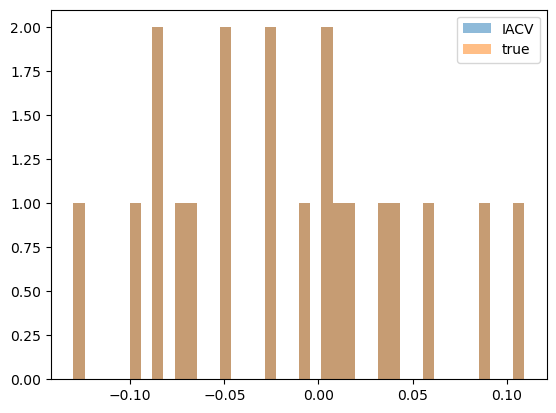

In [11]:
plt.hist(np.mean(clf.loo_iacv_, axis=0), alpha=0.5, bins=40, label="IACV")
plt.hist(np.mean(clf.loo_true_, axis=0), alpha=0.5, bins=40, label="true")
plt.legend()

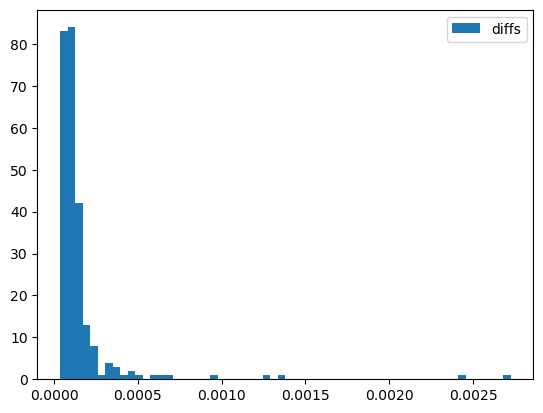

In [12]:
plt.hist(np.linalg.norm(clf.loo_iacv_ - clf.loo_true_, axis=1), bins=60, label="diffs")
plt.legend()

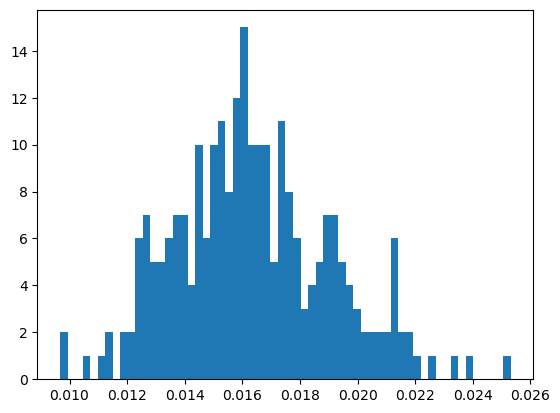

In [13]:
plt.hist(np.linalg.norm(clf.weights_ - clf.loo_true_, axis=1), bins=60, label="diffs")
plt.show()

In [14]:
clf.loo_iacv_

Array([[ 0.09365556, -0.0518626 ,  0.01221938, ...,  0.00824195,
         0.04484996, -0.09635012],
       [ 0.08964925, -0.04715895,  0.01500818, ...,  0.00664434,
         0.04103089, -0.09077981],
       [ 0.08620714, -0.04647775,  0.02325293, ..., -0.0018788 ,
         0.04070489, -0.10192514],
       ...,
       [ 0.09120981, -0.04463662,  0.02368362, ...,  0.00280471,
         0.03987009, -0.09908844],
       [ 0.09338763, -0.04375741,  0.01715579, ...,  0.0052904 ,
         0.04601073, -0.10402327],
       [ 0.08882098, -0.04601655,  0.01805666, ...,  0.01093376,
         0.03829867, -0.09755044]], dtype=float32)

In [15]:
clf.loo_true_

array([[ 0.09361609, -0.05182022,  0.01222147, ...,  0.00823204,
         0.04480353, -0.09632379],
       [ 0.08964005, -0.04715733,  0.01500203, ...,  0.00664147,
         0.0410218 , -0.09071796],
       [ 0.08613996, -0.04645391,  0.02323147, ..., -0.00188711,
         0.04067787, -0.10188446],
       ...,
       [ 0.0911874 , -0.04462857,  0.02368772, ...,  0.00279043,
         0.0398502 , -0.09908314],
       [ 0.0933234 , -0.04372736,  0.01712449, ...,  0.00528916,
         0.0460063 , -0.10400161],
       [ 0.08878762, -0.04600725,  0.0180579 , ...,  0.01095916,
         0.03828512, -0.09752802]])

In [16]:
iacv_mean = np.mean(clf.loo_iacv_, axis=0)
coef = iacv_mean/np.linalg.norm(iacv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.07243871688842773 | pct 0.019685490056872368


In [17]:
true_cv_mean = np.mean(clf.loo_true_, axis=0)
coef = true_cv_mean/np.linalg.norm(true_cv_mean)
print(f"diff {np.mean(np.abs(coef - sk_coef))} | pct {np.mean(np.abs(coef - sk_coef))/np.sum(np.abs(coef))}")

diff 0.07243902703601093 | pct 0.019685962940407257


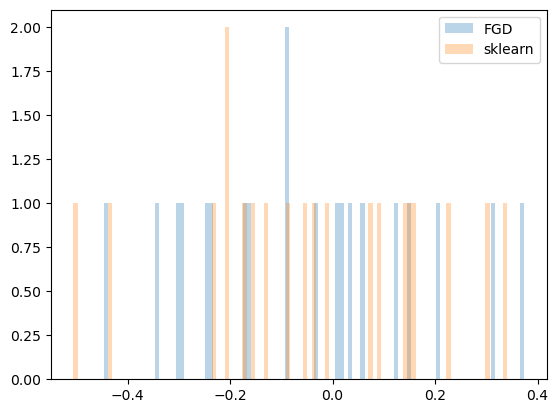

In [18]:
coef = clf.weights_/np.linalg.norm(clf.weights_)
nbin = 100
plt.hist(coef, bins=nbin, label="FGD", alpha=0.3)
plt.hist(sk_coef.flatten(), bins=nbin, label="sklearn", alpha=0.3)
plt.legend()
plt.show()

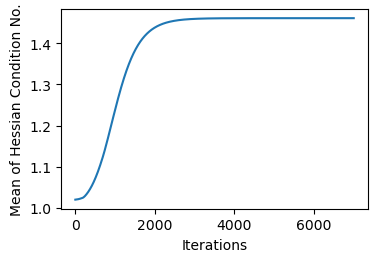

<Figure size 640x480 with 0 Axes>

In [19]:
fig, ax = plt.subplots()
ax.plot(np.max(clf.cond_nums_, axis=1))
#ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Mean of Hessian Condition No.")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_cond_no.pgf', bbox_inches='tight', pad_inches=0)

In [20]:
np.mean(clf.cond_nums_, axis=1)[np.argmax(np.mean(clf.cond_nums_, axis=1))]

1.2660471

(array([242.,   4.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   1.]),
 array([1.26094413, 1.28094268, 1.30094135, 1.3209399 , 1.34093857,
        1.36093712, 1.38093567, 1.40093434, 1.42093289, 1.44093156,
        1.46093011]),
 <BarContainer object of 10 artists>)

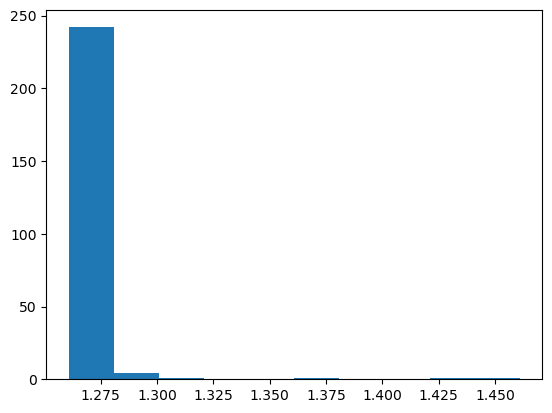

In [21]:
plt.hist(np.median(clf.cond_nums_, axis=0))

In [25]:
fig, ax = plt.subplots()
ax.plot(clf.err_approx_["IACV"], label="IACV", c='black')
#ax.plot(clf.err_approx_["NS"], label="NS", c='red', linestyle="--")
ax.plot(clf.err_approx_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err Approx (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_err_approx_mod.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_18123/1490785451.py:13: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [26]:
fig, ax = plt.subplots()
ax.plot(clf.err_cv_["IACV"], label="IACV", c='black')
ax.plot(clf.err_cv_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err CV (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
plt.savefig('svm_convergence_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_18123/3441285585.py:12: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()
